In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile
import glob, random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

In [5]:
WIKIART_PATH = "/content/drive/MyDrive/CMPE258/project/archive"
COCO_PATH = "/content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017"

print("WikiArt:", os.path.exists(WIKIART_PATH))
print("COCO:", os.path.exists(COCO_PATH))


WikiArt: True
COCO: True


In [6]:
coco_images = glob.glob(f"{COCO_PATH}/*.jpg")
print("Found", len(coco_images), "COCO images")

wikiart_images = glob.glob(f"{WIKIART_PATH}/**/*.jpg", recursive=True)
print("Found", len(wikiart_images), "WikiArt images")

content_img = random.choice(coco_images)
style_img = random.choice(wikiart_images)

print("Content image:", content_img)
print("Style image:", style_img)


Found 123404 COCO images
Found 81444 WikiArt images
Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000274169.jpg
Style image: /content/drive/MyDrive/CMPE258/project/archive/Art_Nouveau_Modern/carl-larsson_brita-at-the-piano-1908(1).jpg


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 512

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

def load_image(path):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")


In [8]:
vgg = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features.to(device).eval()

# Extract intermediate layers for content & style
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [9]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

In [39]:
def style_transfer(content, style, model, content_weight=1, style_weight=1e6, steps=5000, stop_threshold=10000):

    target = content.clone().requires_grad_(True).to(device) # Target Image
    optimizer = torch.optim.Adam([target], lr=0.005)

    for i in range(steps):
        target_features = get_features(target, model)
        content_features = get_features(content, model)
        style_features = get_features(style, model)

        # Content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']:
            target_f = target_features[layer]
            style_f = style_features[layer]
            _, c, h, w = target_f.shape
            target_gram = torch.mm(target_f.view(c, h * w), target_f.view(c, h * w).t())
            style_gram = torch.mm(style_f.view(c, h * w), style_f.view(c, h * w).t())
            layer_style_loss = torch.mean((target_gram - style_gram)**2) / (c * h * w)
            style_loss += layer_style_loss

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Step [{i}/{steps}]  Total Loss: {total_loss.item():.2f}")

        if total_loss.item() < stop_threshold:
            print(f"Stopping early at step {i}, total loss = {total_loss.item():.2f}")
            break

    return target


Content image: /content/drive/MyDrive/CMPE258/project/unlabeled2017/unlabeled2017/000000160675.jpg


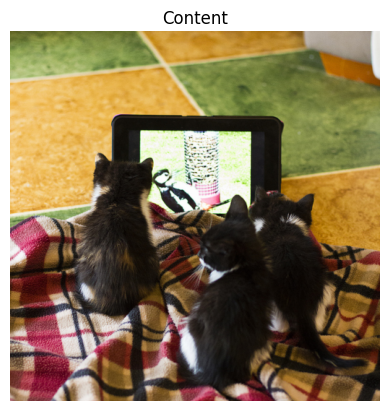

In [32]:
content_img = f"{COCO_PATH}/000000160675.jpg"
# content_img = random.choice(coco_images)

content = load_image(content_img)
imshow(content, "Content")
print("Content image:", content_img)


Style image: /content/drive/MyDrive/CMPE258/project/archive/Post_Impressionism/constantine-maleas_olympia.jpg


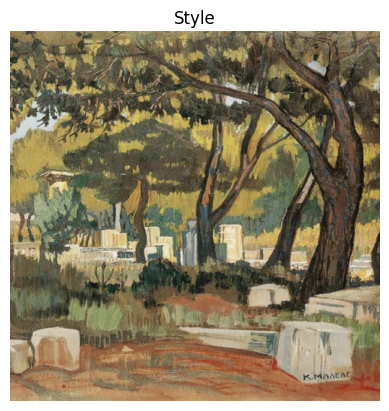

In [34]:
style_img= f"{WIKIART_PATH}/Post_Impressionism/constantine-maleas_olympia.jpg"
# style_img = random.choice(wikiart_images)
style = load_image(style_img)
imshow(style, "Style")
print("Style image:", style_img)


Step [0/5000]  Total Loss: 11066583.00
Step [100/5000]  Total Loss: 357270.22
Step [200/5000]  Total Loss: 200244.19
Step [300/5000]  Total Loss: 140638.61
Step [400/5000]  Total Loss: 106946.45
Step [500/5000]  Total Loss: 85581.11
Step [600/5000]  Total Loss: 71140.88
Step [700/5000]  Total Loss: 61022.92
Step [800/5000]  Total Loss: 53699.45
Step [900/5000]  Total Loss: 48200.36
Step [1000/5000]  Total Loss: 43929.76
Step [1100/5000]  Total Loss: 40510.80
Step [1200/5000]  Total Loss: 37701.95
Step [1300/5000]  Total Loss: 35332.21
Step [1400/5000]  Total Loss: 33300.75
Step [1500/5000]  Total Loss: 31528.25
Step [1600/5000]  Total Loss: 29967.08
Step [1700/5000]  Total Loss: 28575.90
Step [1800/5000]  Total Loss: 27326.70
Step [1900/5000]  Total Loss: 26193.21
Step [2000/5000]  Total Loss: 25159.17
Step [2100/5000]  Total Loss: 24212.83
Step [2200/5000]  Total Loss: 23341.88
Step [2300/5000]  Total Loss: 22532.03
Step [2400/5000]  Total Loss: 21779.55
Step [2500/5000]  Total Loss: 

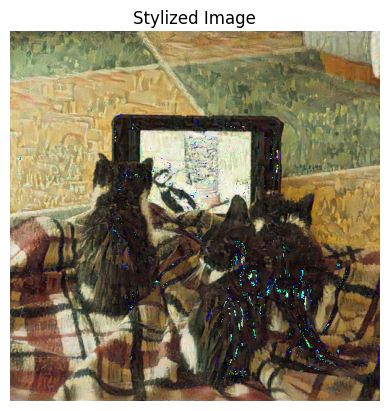

In [37]:
output = style_transfer(content, style, vgg, steps=5000, stop_threshold=10000)
imshow(output, "Stylized Image")